<a href="https://colab.research.google.com/github/Amisha1019/Image-Colorization-and-Generative-AI/blob/main/Task_6_of_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!python real_time_video_colorization.py --source /mnt/data/colab_test_video.mp4 --out output_colorized.mp4


python3: can't open file '/content/real_time_video_colorization.py': [Errno 2] No such file or directory


In [20]:
!python real_time_video_colorization.py --source 0


python3: can't open file '/content/real_time_video_colorization.py': [Errno 2] No such file or directory


In [19]:
!python real_time_video_colorization.py --source /mnt/data/colab_test_video.mp4 --ref ref_color.jpg


python3: can't open file '/content/real_time_video_colorization.py': [Errno 2] No such file or directory


In [22]:
import cv2
import numpy as np
import argparse
import time
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image


In [23]:
class UNetLite(nn.Module):
    def __init__(self):
        super().__init__()
        def C(i,o): return nn.Sequential(nn.Conv2d(i,o,3,padding=1), nn.ReLU(inplace=True))
        self.enc1 = C(1,32)
        self.enc2 = C(32,64)
        self.pool = nn.MaxPool2d(2)
        self.up1 = nn.ConvTranspose2d(64,32,2,stride=2)
        self.dec1 = C(64,32)
        self.final = nn.Conv2d(32,3,1)
    def forward(self,x):
        e1 = self.enc1(x)       # b 32 H W
        p1 = self.pool(e1)      # b 32 H/2 W/2
        e2 = self.enc2(p1)      # b 64 H/2 W/2
        u1 = self.up1(e2)       # b 32 H W
        d1 = self.dec1(torch.cat([u1,e1], dim=1))
        out = torch.sigmoid(self.final(d1))
        return out

In [24]:
def color_transfer(source_rgb, target_rgb):
    """
    Transfers color distribution from source_rgb to target_rgb.
    Both images are RGB uint8 numpy arrays, same shape ideally.
    Returns color-transferred RGB uint8 image.
    """
    # Convert to LAB
    src = cv2.cvtColor(source_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
    tar = cv2.cvtColor(target_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)

    # compute mean and std for each channel
    src_mean, src_std = cv2.meanStdDev(src)
    tar_mean, tar_std = cv2.meanStdDev(tar)

    # subtract mean, scale by std ratio, add src mean
    eps = 1e-6
    result = (tar - tar_mean.reshape(1,1,3)) * (src_std.reshape(1,1,3) / (tar_std.reshape(1,1,3)+eps)) + src_mean.reshape(1,1,3)
    result = np.clip(result, 0, 255).astype(np.uint8)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
    return result

In [25]:
def open_video_source(source):
    # If source is digit string, convert to int (webcam). But on hosted environments, webcam often unavailable.
    try:
        if isinstance(source, str) and source.isdigit():
            source = int(source)
    except Exception:
        pass
    cap = cv2.VideoCapture(source)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video source: {source}")
    return cap


In [26]:
def frame_to_gray_tensor(frame, device, target_size=None):
    # frame is RGB uint8
    img = Image.fromarray(frame)
    if target_size is not None:
        img = img.resize(target_size, Image.BILINEAR)
    transform = T.Compose([T.ToTensor()])  # 0..1
    gray = img.convert('L')
    t = transform(gray).unsqueeze(0).to(device)  # shape [1,1,H,W]
    return t, img.size

In [33]:
import cv2
import numpy as np
import argparse
import time
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
from google.colab.patches import cv2_imshow

def process_video(source,
                  out_path=None,
                  model_choice='color-transfer',
                  ref_image_path=None,
                  unet_weights=None,
                  frame_width=640,
                  frame_height=360,
                  device_str='cuda' if torch.cuda.is_available() else 'cpu'):
    device = torch.device(device_str)
    print(f"[INFO] using device: {device}")

    # open source
    cap = open_video_source("/content/colab_test_video.mp4")
    orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    print(f"[INFO] source resolution: {orig_w}x{orig_h} @ {fps} FPS")

    # output writer
    writer = None
    if out_path is not None:
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        writer = cv2.VideoWriter(out_path, fourcc, fps, (frame_width*2, frame_height))  # side-by-side

    # load models
    unet = None
    if model_choice in ('unet', 'all'):
        unet = UNetLite().to(device)
        if unet_weights is not None and os.path.exists(unet_weights):
            state = torch.load(unet_weights, map_location=device)
            unet.load_state_dict(state)
            print("[INFO] loaded UNet weights from", unet_weights)
        unet.eval()

    ref_img = None
    if ref_image_path is not None and os.path.exists(ref_image_path):
        pil = Image.open(ref_image_path).convert('RGB')
        ref_img = np.array(pil)
        print("[INFO] loaded reference image for color-transfer:", ref_image_path)

    paused = False
    model_idx = 0
    models = []
    if model_choice == 'all':
        models = ['color-transfer','unet']
    elif model_choice in ('color-transfer','unet'):
        models = [model_choice]
    else:
        models = [model_choice]

    # if ref not provided and color-transfer is requested, use first color frame as ref later
    dynamic_ref = None

    last_time = time.time()
    frame_count = 0
    t0 = time.time()

    print("[INFO] Controls: 'm' switch model | 'p' pause/play | 's' save current frame | 'q' quit")
    print("[INFO] Starting processing...")

    while True:
        if not paused:
            grabbed, frame_bgr = cap.read()
            if not grabbed:
                print("[INFO] End of stream or cannot grab frame.")
                break

            # resize frame for speed
            frame_bgr_small = cv2.resize(frame_bgr, (frame_width, frame_height))
            frame_rgb = cv2.cvtColor(frame_bgr_small, cv2.COLOR_BGR2RGB)

            # If we don't have a reference image for color-transfer, use the first color frame as reference
            if ref_img is None and (models[model_idx] == 'color-transfer' or models[model_idx] == 'all'):
                if dynamic_ref is None:
                    dynamic_ref = frame_rgb.copy()

            # run chosen model
            model_name = models[model_idx]

            if model_name == 'color-transfer':
                ref = ref_img if ref_img is not None else dynamic_ref
                # target is frame converted to grayscale then color-matched to ref
                gray = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2GRAY)
                gray_3c = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
                colorized = color_transfer(ref, gray_3c)

            elif model_name == 'unet':
                # run UNet: input grayscale normalized to 0..1
                t_gray, (W,H) = frame_to_gray_tensor(frame_rgb, device, target_size=(frame_width, frame_height))
                with torch.no_grad():
                    pred = unet(t_gray)  # [1,3,H,W]
                out_np = (pred[0].permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
                colorized = out_np  # already RGB-like

            else:
                # fallback: simple colorization by histogram equalization on V channel
                hsv = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2HSV)
                hsv[:,:,2] = cv2.equalizeHist(hsv[:,:,2])
                colorized = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

            # side-by-side display: left grayscale, right colorized
            gray_display = cv2.cvtColor(cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
            side = np.concatenate([gray_display, colorized], axis=1)  # RGB
            # overlay text
            cv2.putText(side, f"Model: {model_name}", (10,20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)
            frame_count += 1

            # compute FPS and overlay
            if frame_count % 10 == 0:
                now = time.time()
                fps_display = 10.0 / (now - last_time + 1e-6)
                last_time = now
            else:
                fps_display = None
            if fps_display is not None:
                cv2.putText(side, f"FPS: {fps_display:.1f}", (10,40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)

            # convert to BGR for imshow
            side_bgr = cv2.cvtColor(side, cv2.COLOR_RGB2BGR)

            cv2_imshow(side_bgr)

            if writer is not None:
                # writer expects BGR; frames size must match writer configured size
                # ensure side_bgr size equals (frame_height, frame_width*2)
                out_frame = cv2.resize(side_bgr, (frame_width*2, frame_height))
                writer.write(out_frame)

        # key handling
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            print("[INFO] Quit pressed.")
            break
        elif key == ord('p'):
            paused = not paused
            print("[INFO] Paused" if paused else "[INFO] Resumed")
            # when paused, still allow switching
        elif key == ord('m'):
            # switch model
            model_idx = (model_idx + 1) % len(models)
            print(f"[INFO] Switched to model: {models[model_idx]}")
        elif key == ord('s'):
            # save current side-by-side frame
            save_path = f"colorized_snapshot_{int(time.time())}.png"
            if 'side_bgr' in locals():
                cv2.imwrite(save_path, side_bgr)
                print(f"[INFO] Saved snapshot: {save_path}")
            else:
                print("[WARN] No frame to save yet.")

    cap.release()
    if writer:
        writer.release()
        print("[INFO] Saved output video to", out_path)
    cv2.destroyAllWindows()
    tot = time.time() - t0
    print(f"[INFO] Processed frames: {frame_count} in {tot:.2f}s. Avg FPS: {frame_count/(tot+1e-6):.2f}")

[INFO] using device: cpu
[INFO] source resolution: 320x240 @ 24.0 FPS
[INFO] Controls: 'm' switch model | 'p' pause/play | 's' save current frame | 'q' quit
[INFO] Starting processing...


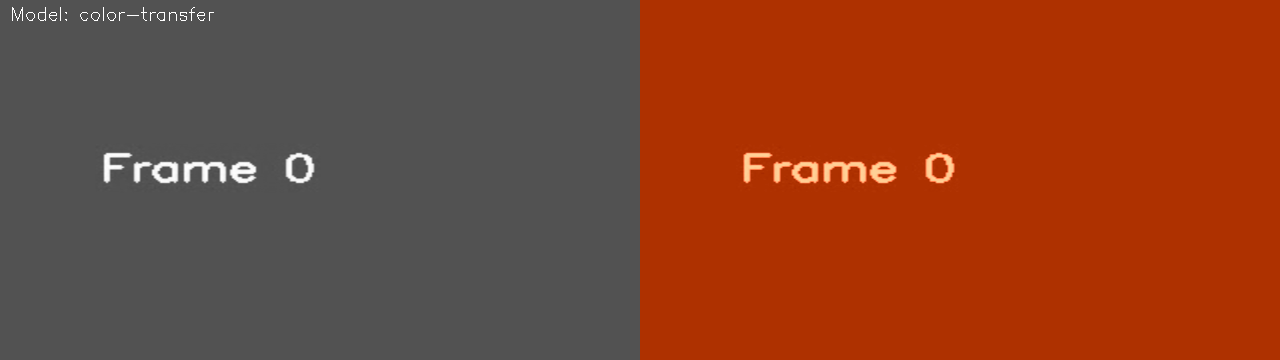

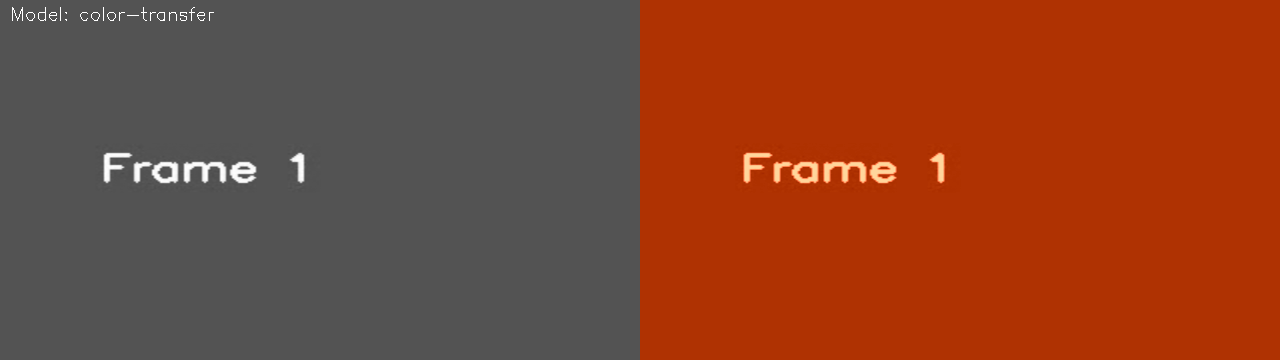

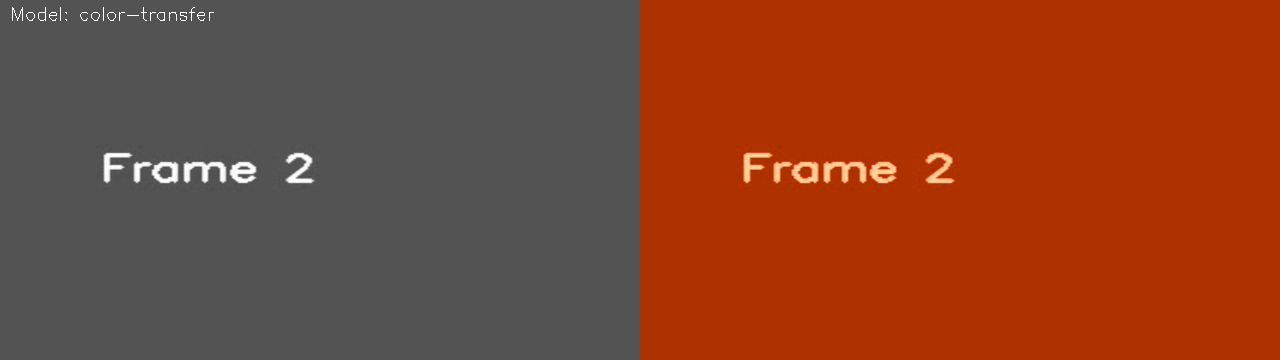

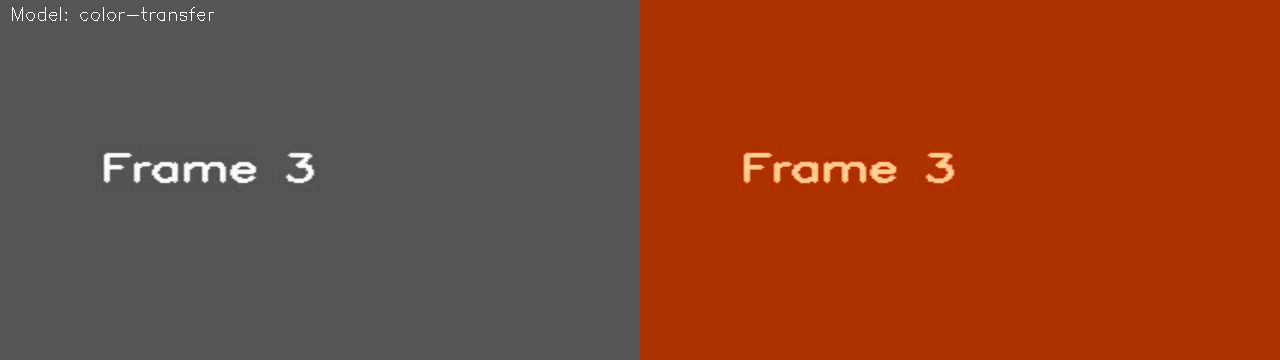

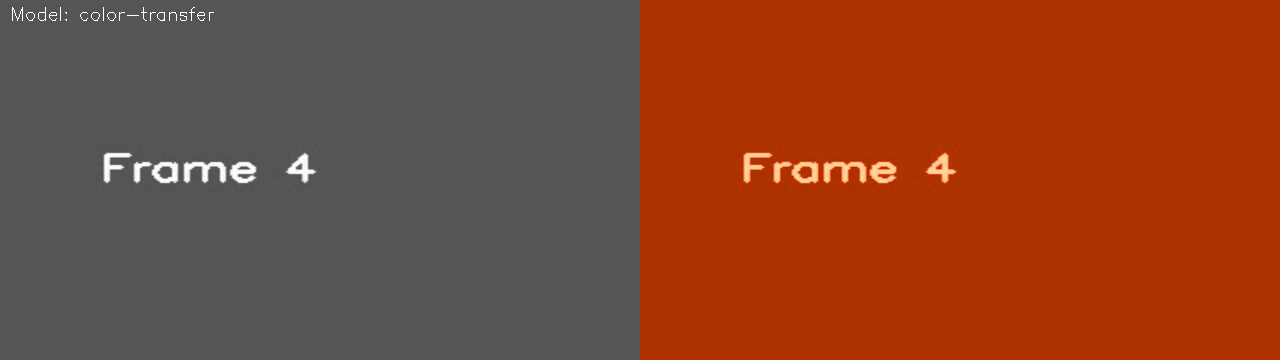

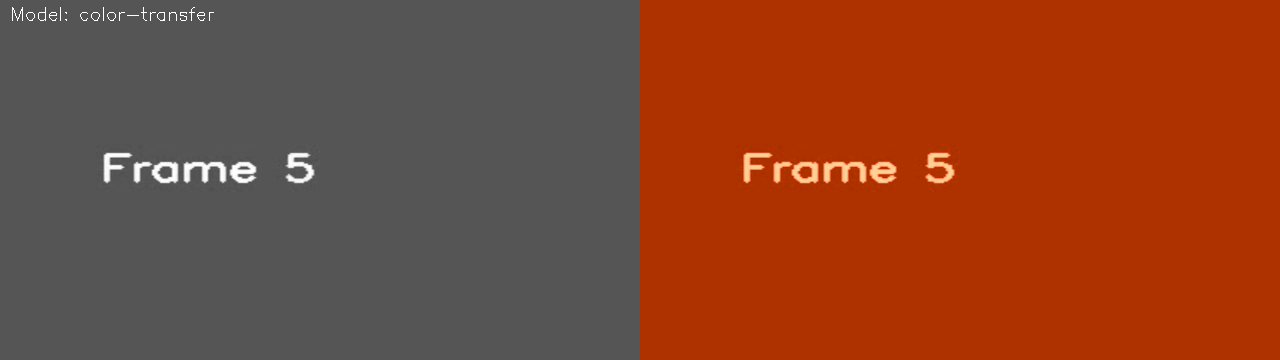

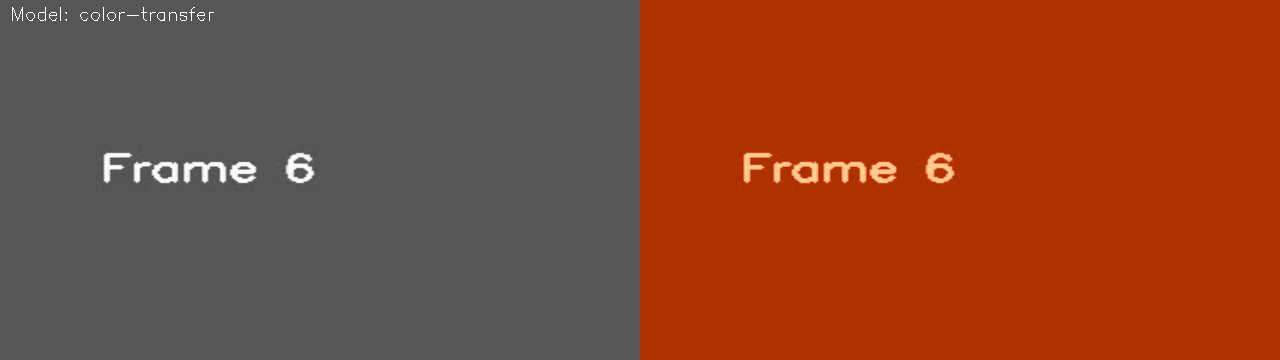

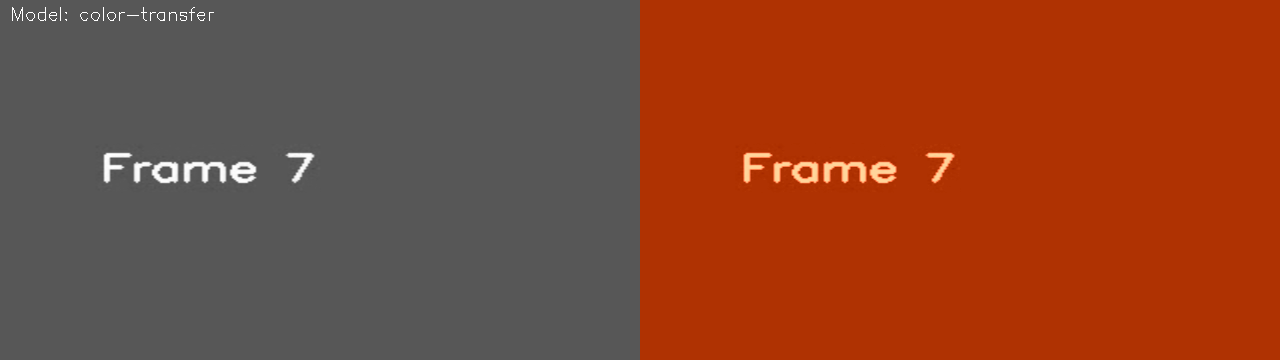

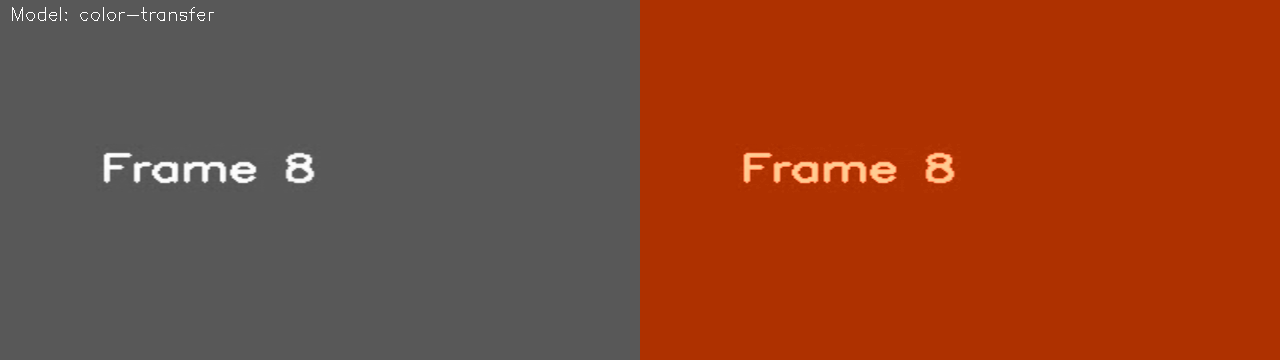

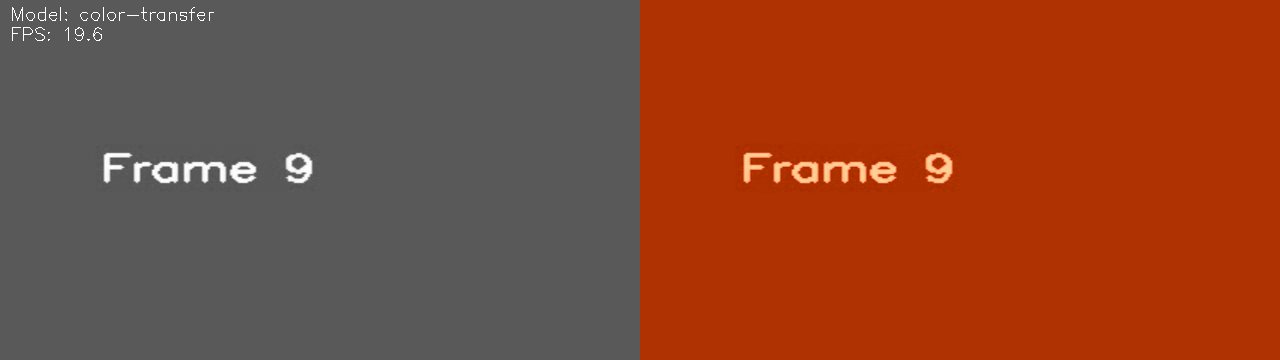

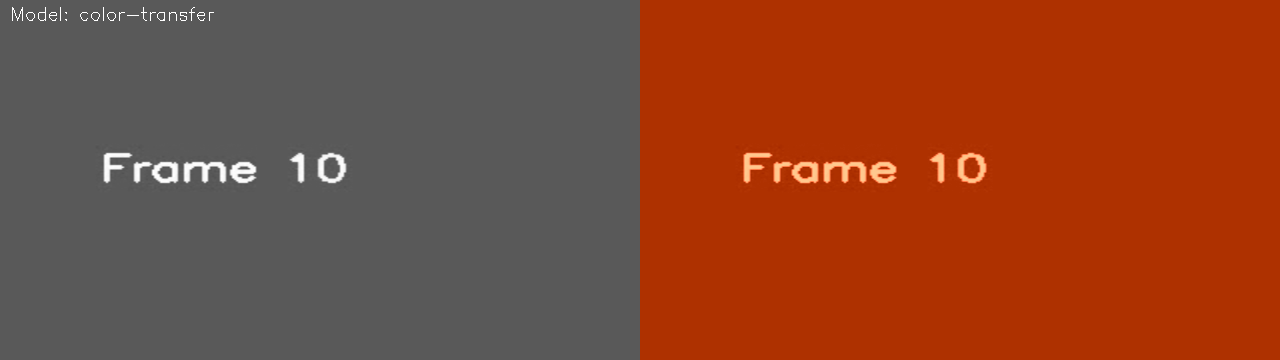

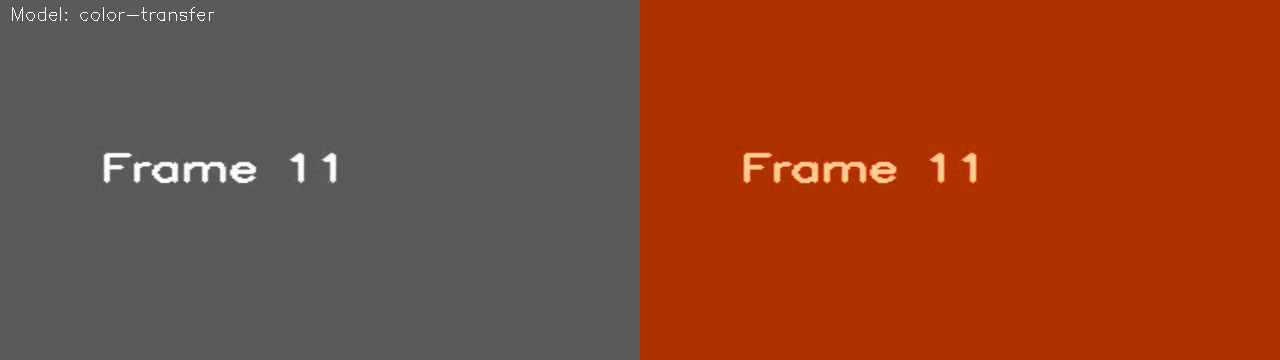

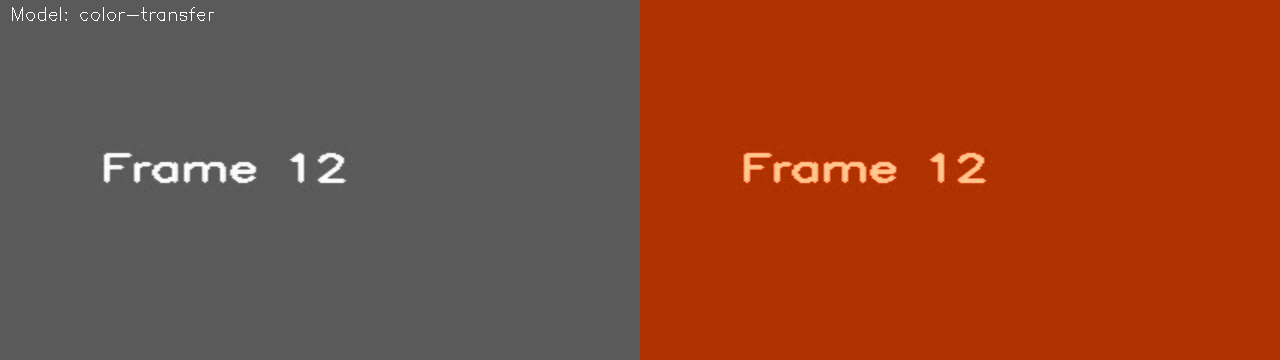

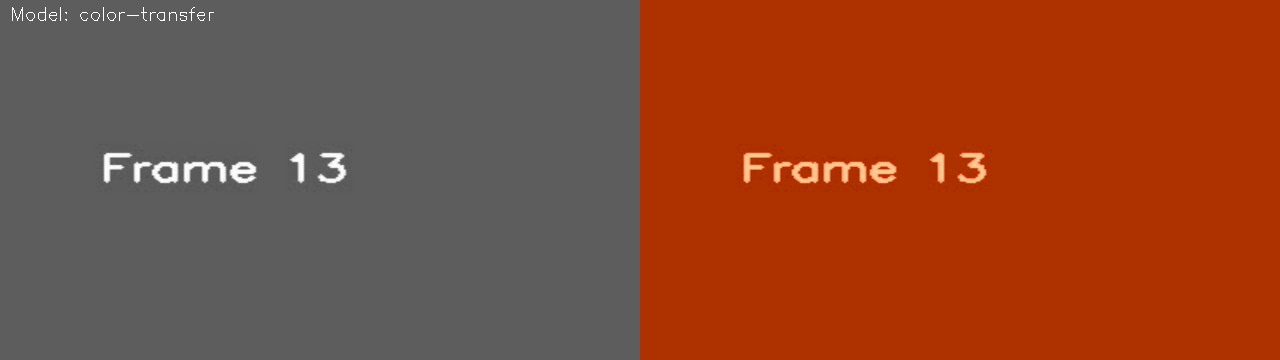

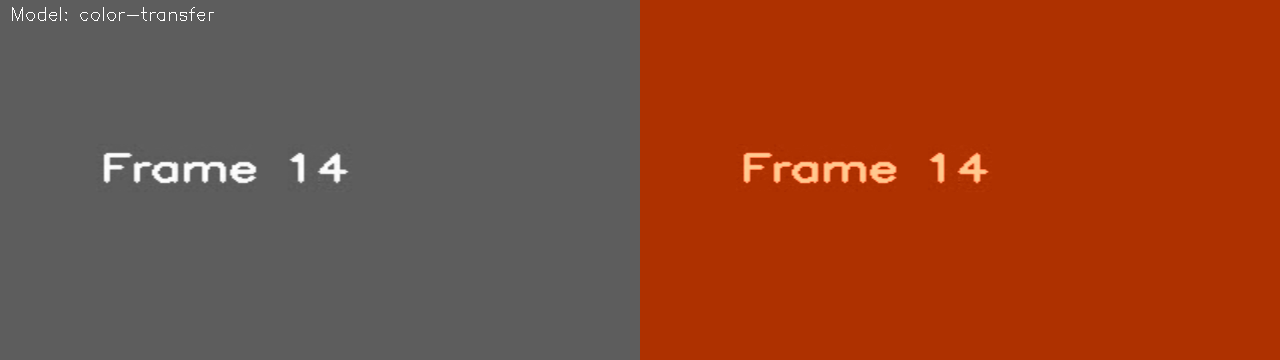

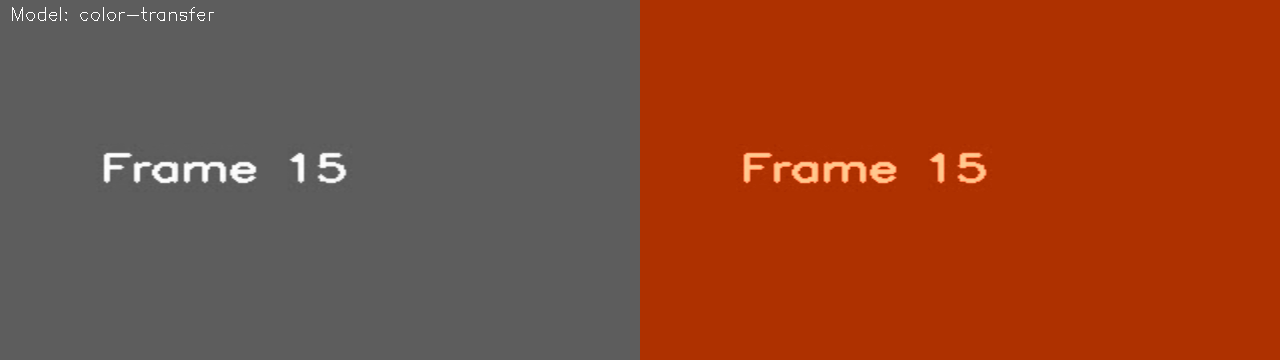

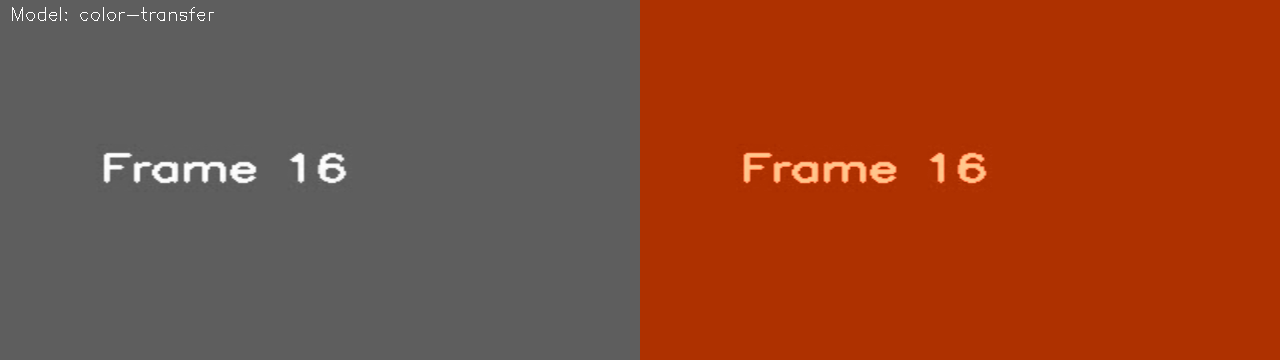

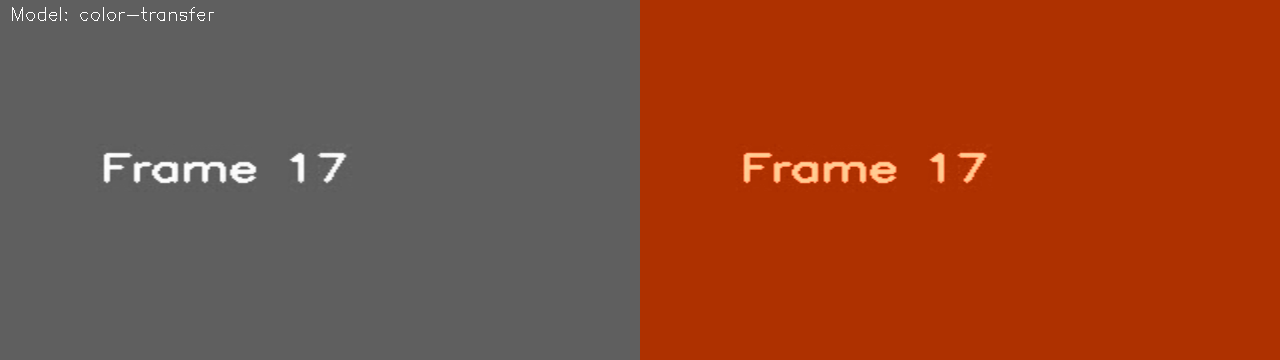

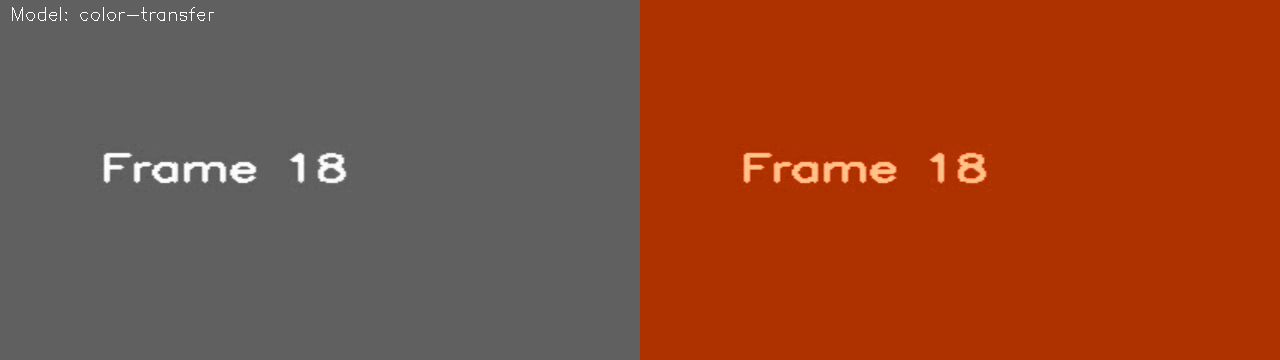

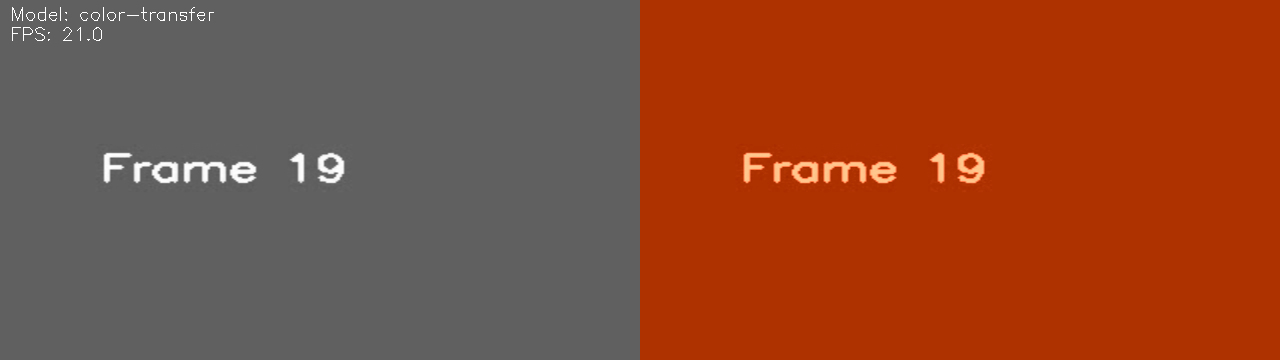

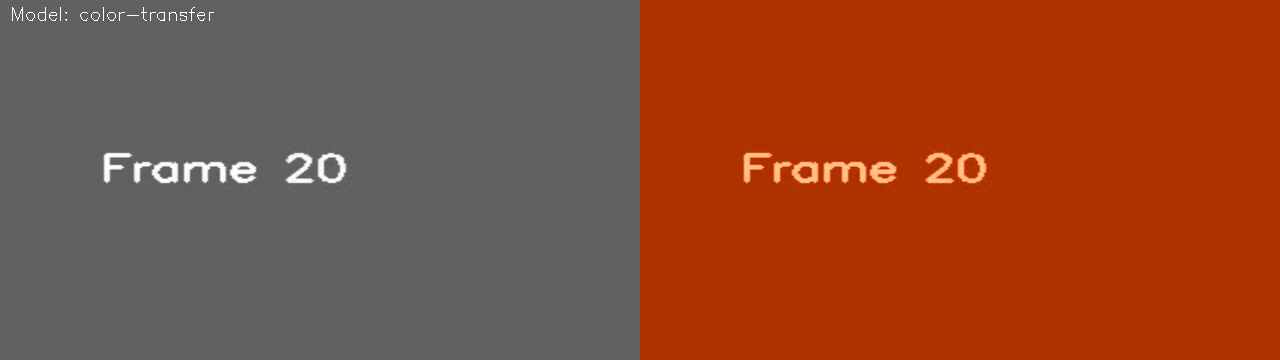

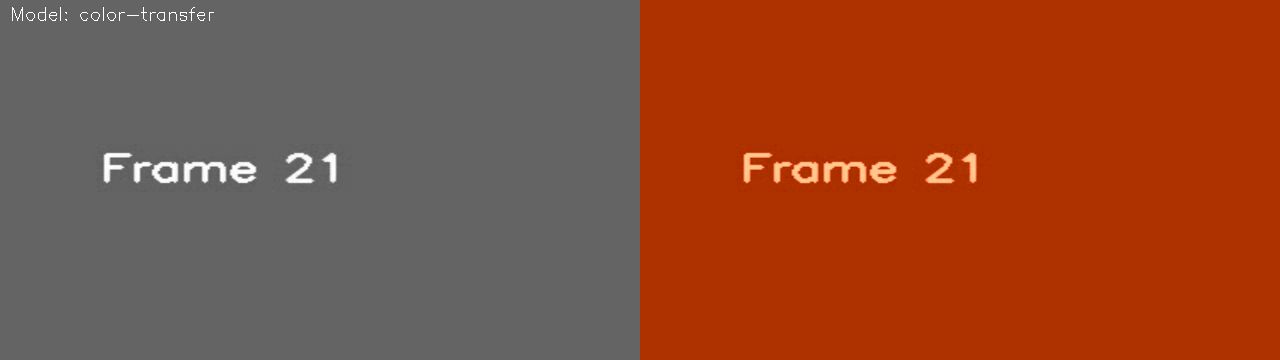

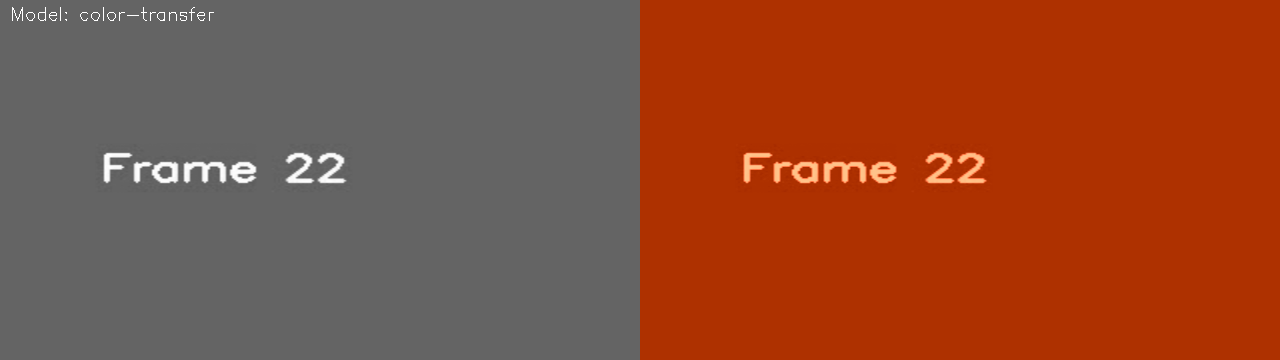

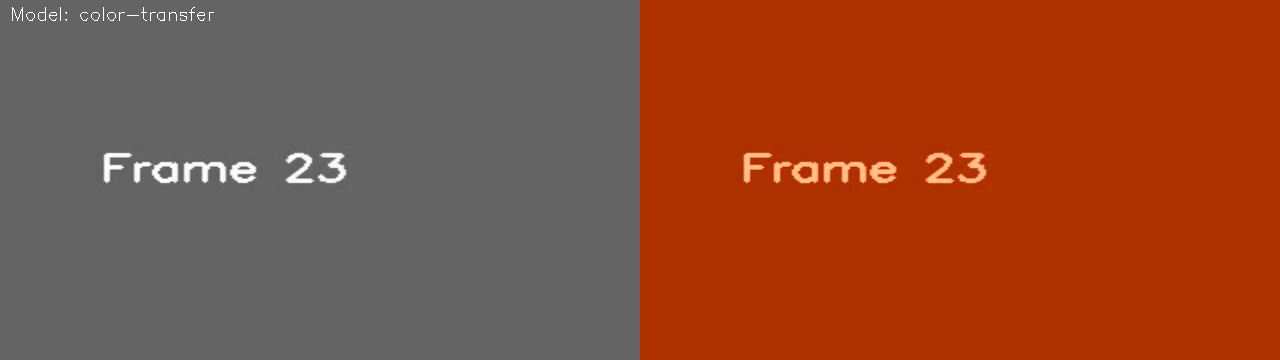

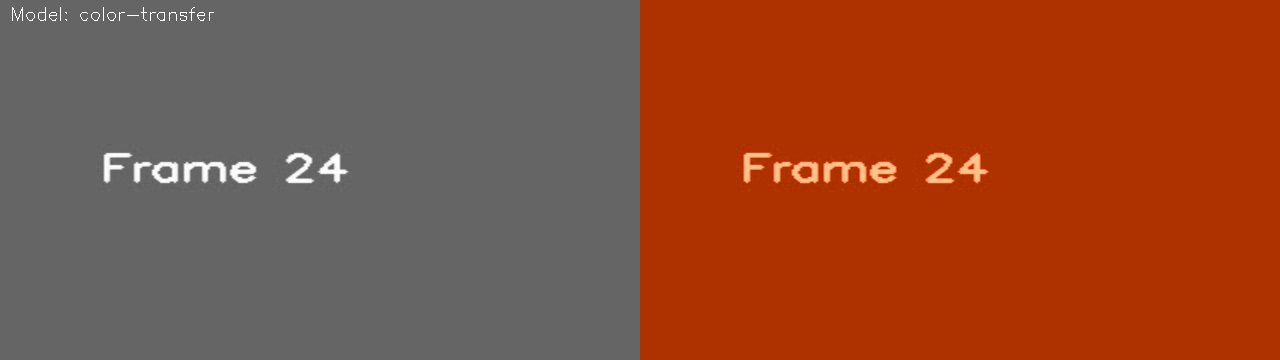

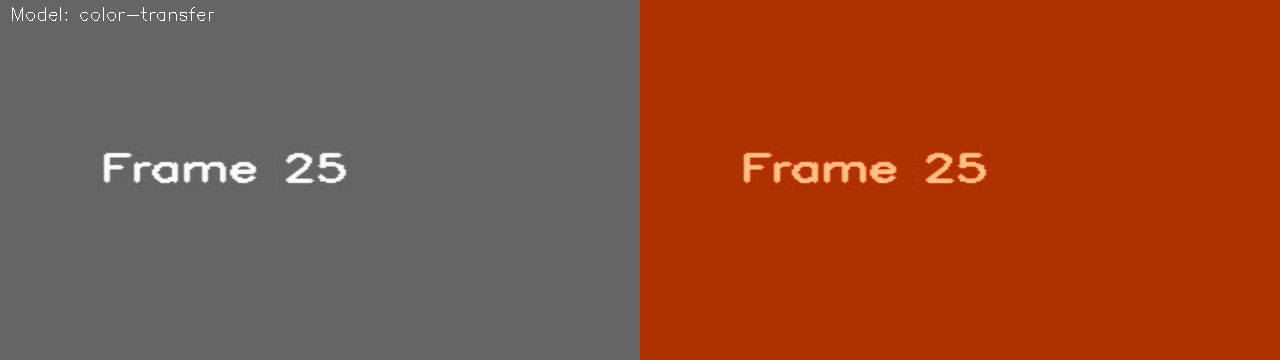

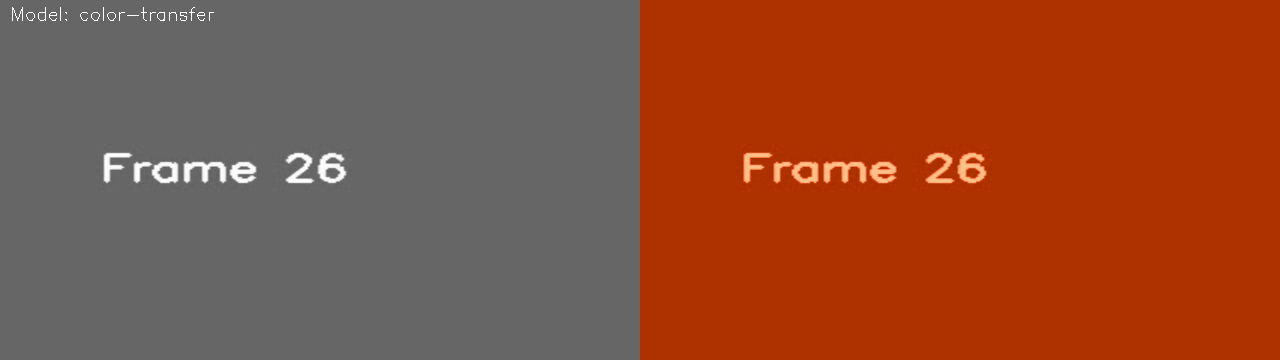

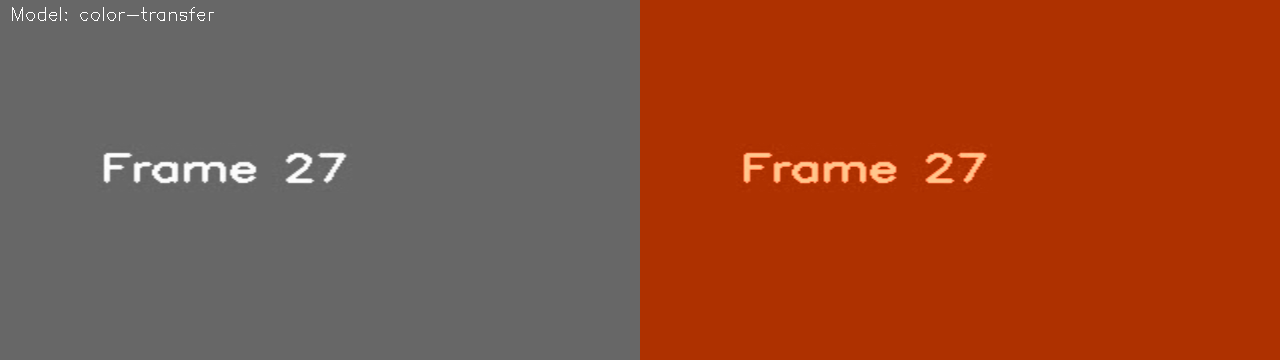

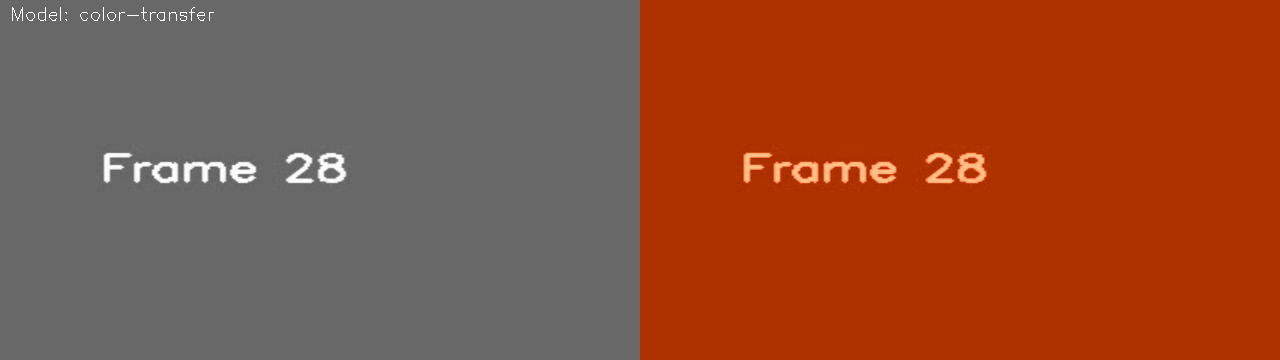

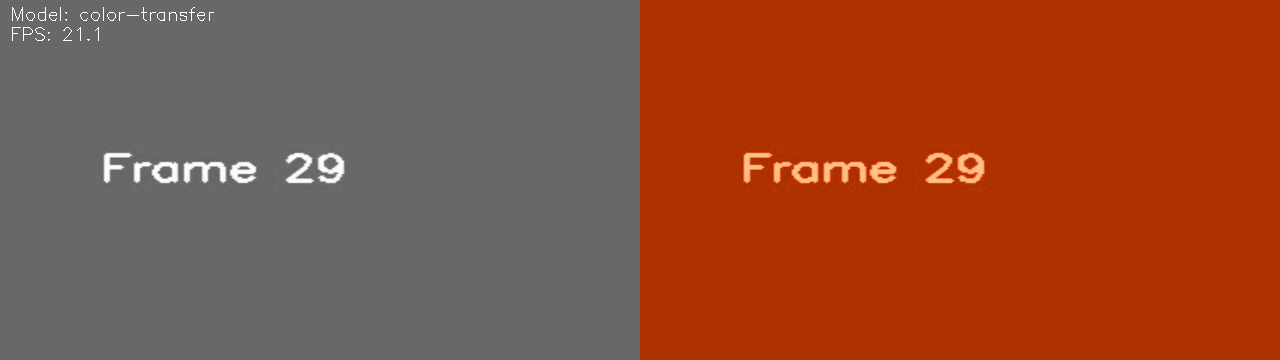

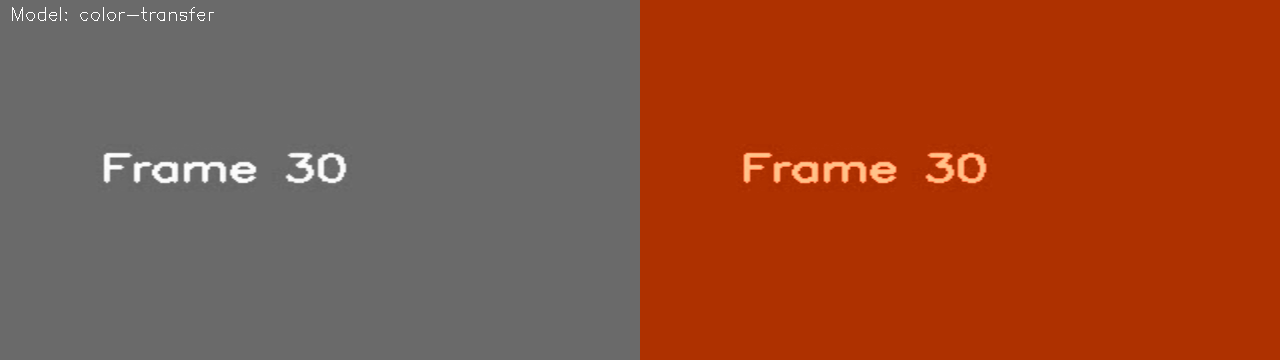

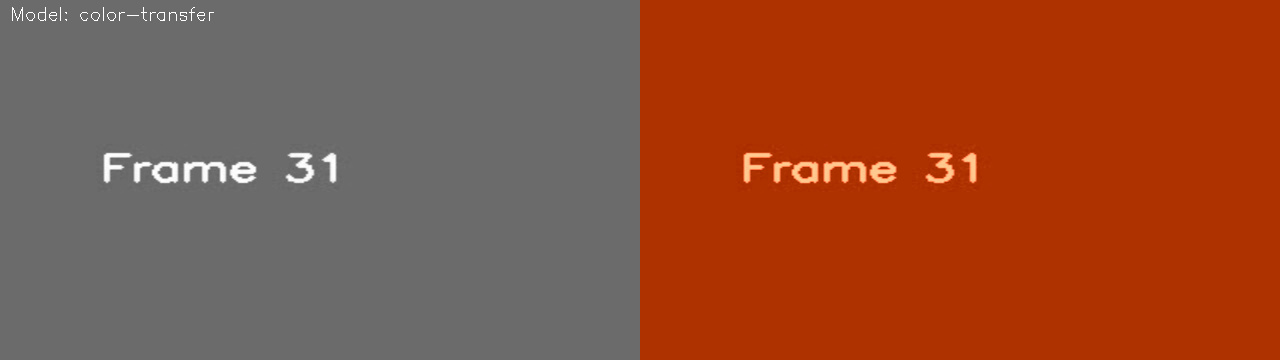

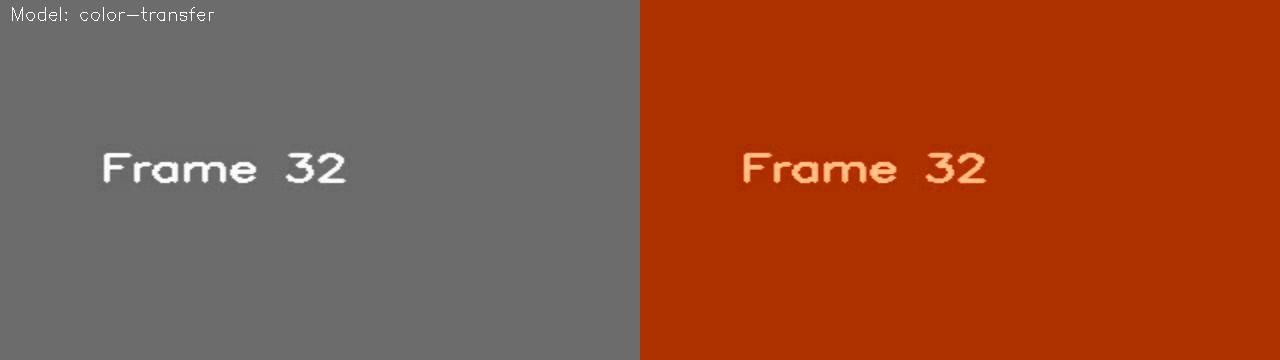

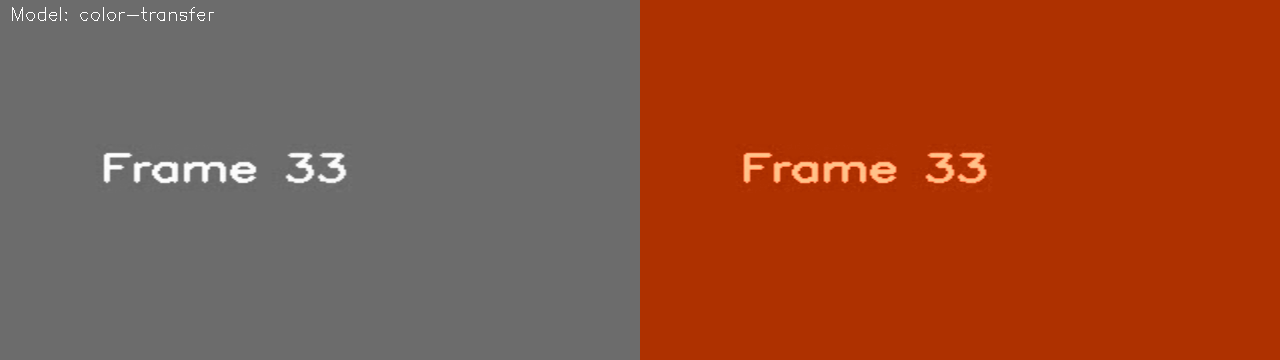

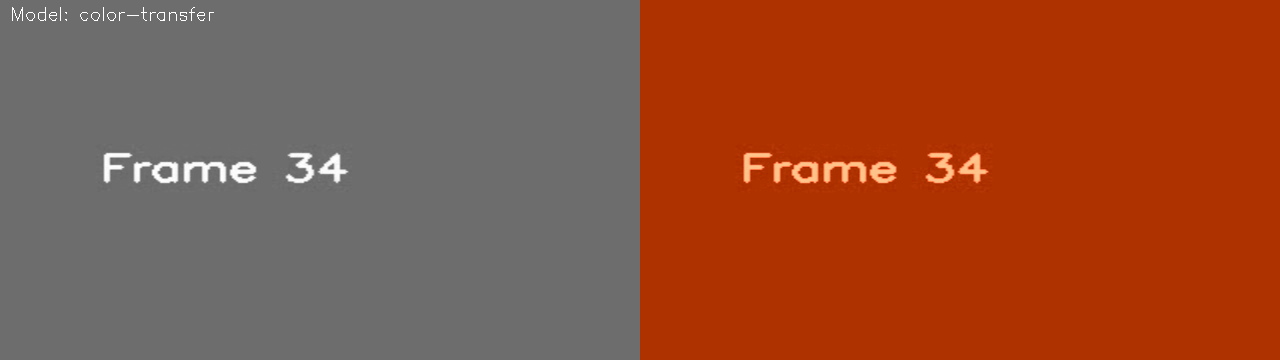

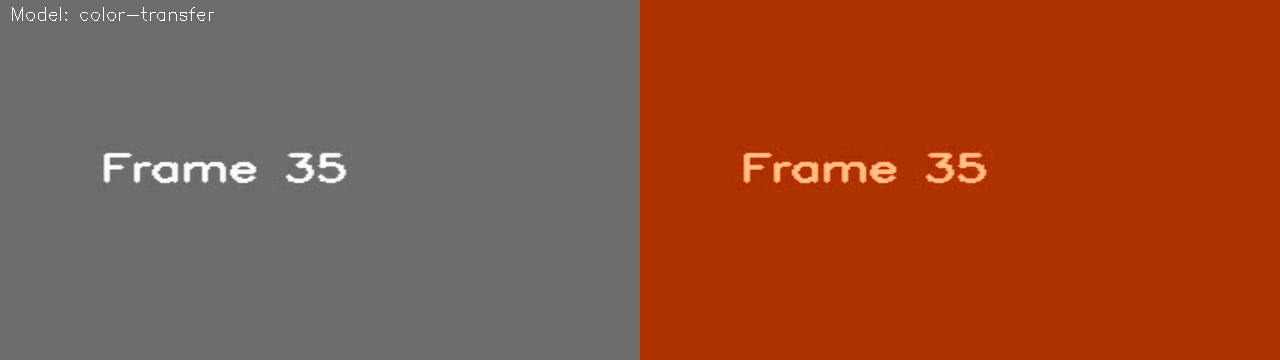

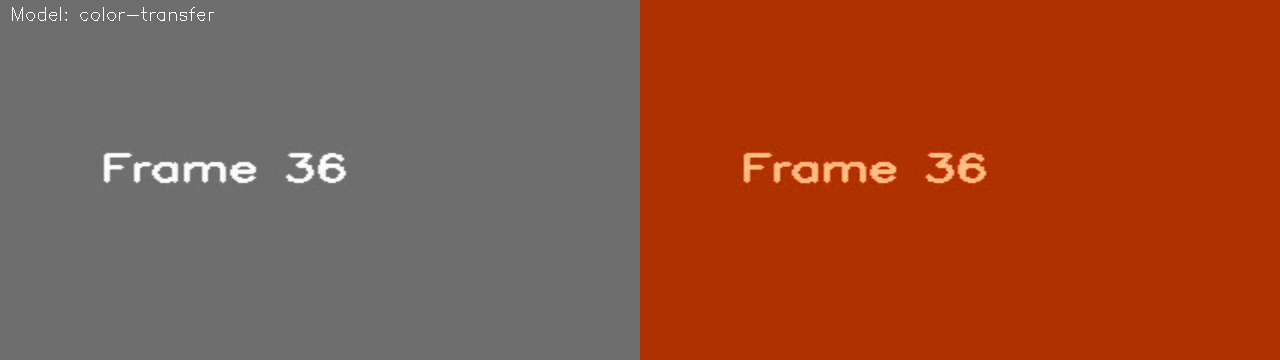

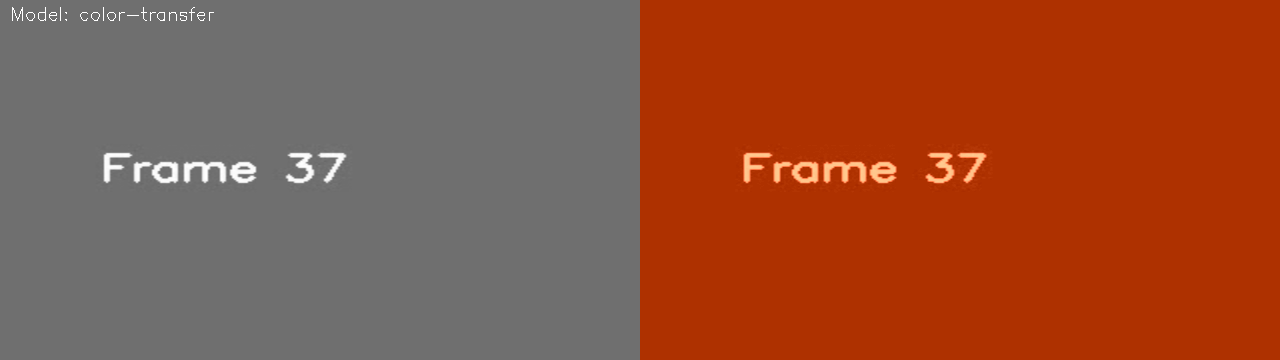

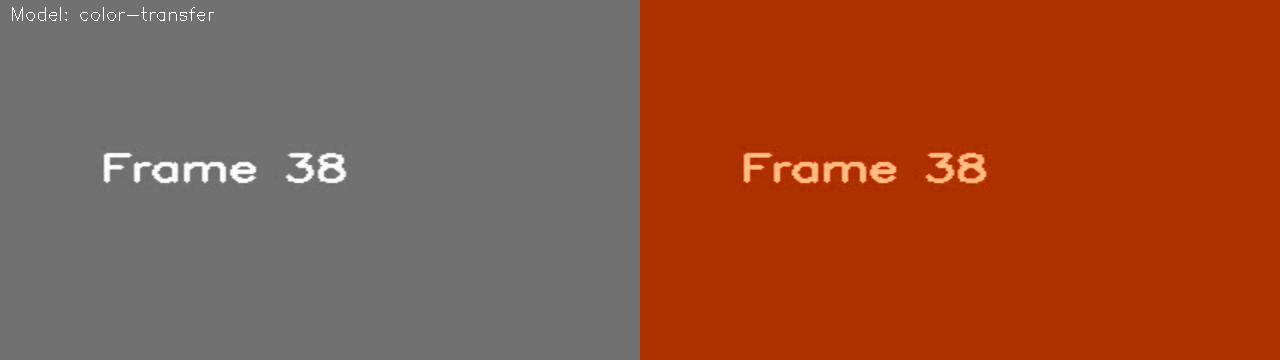

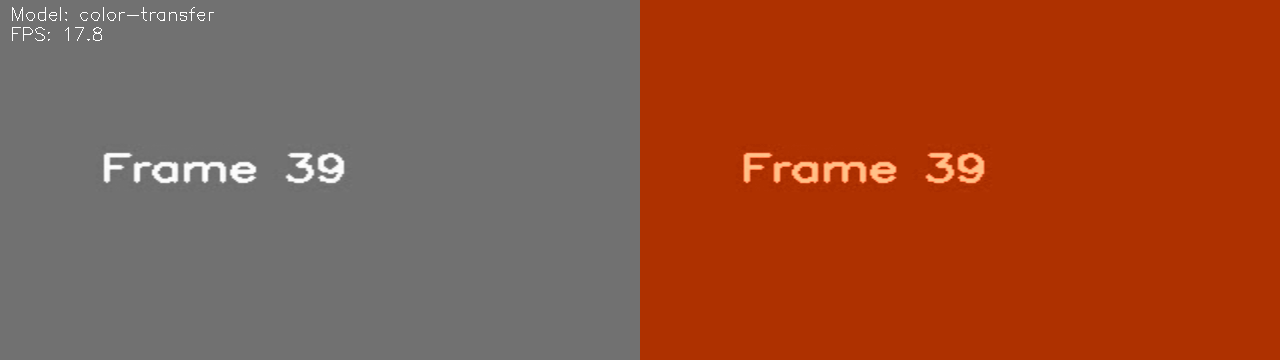

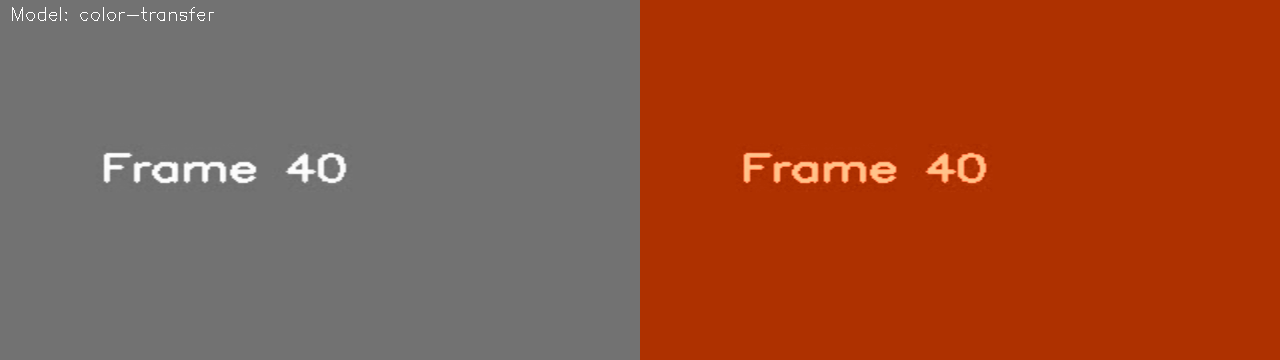

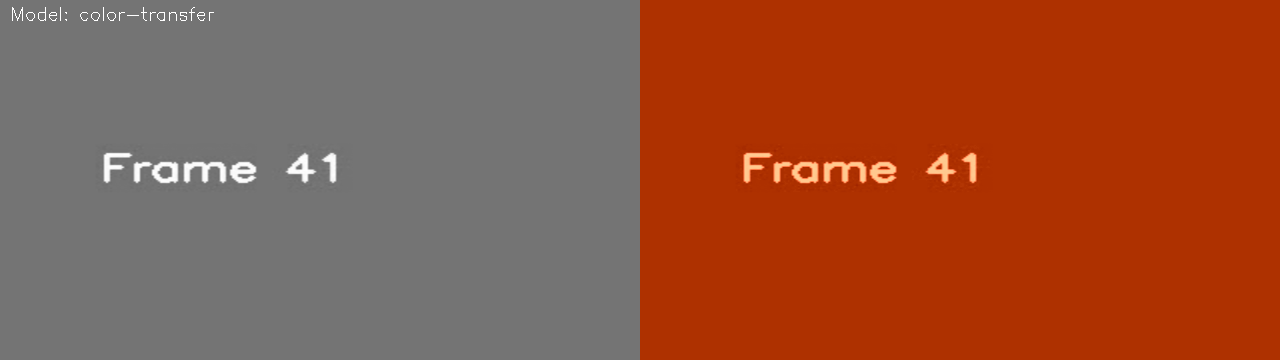

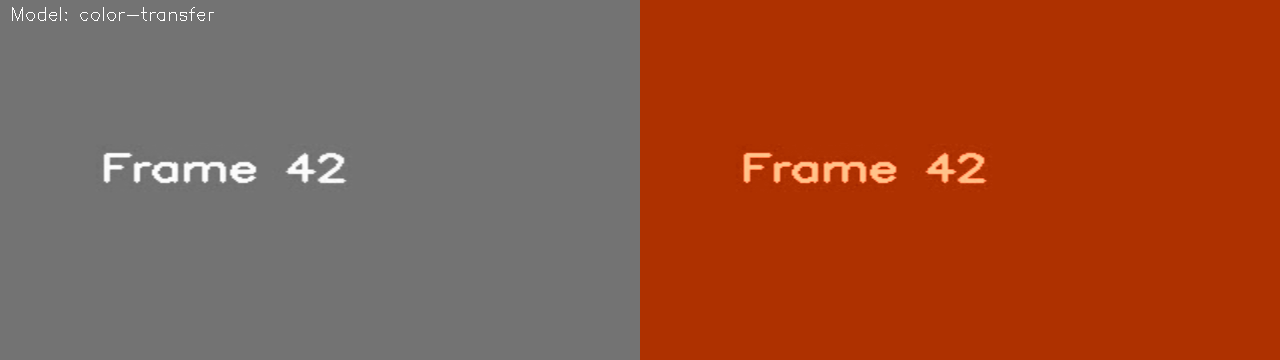

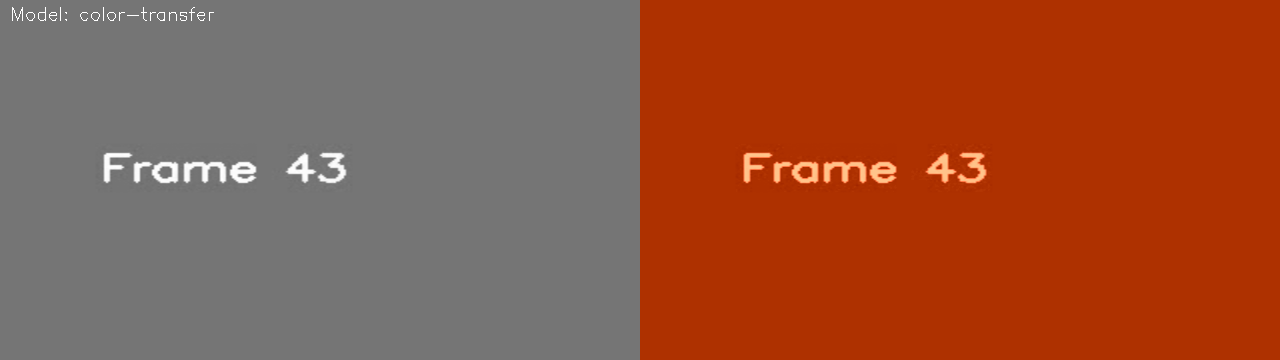

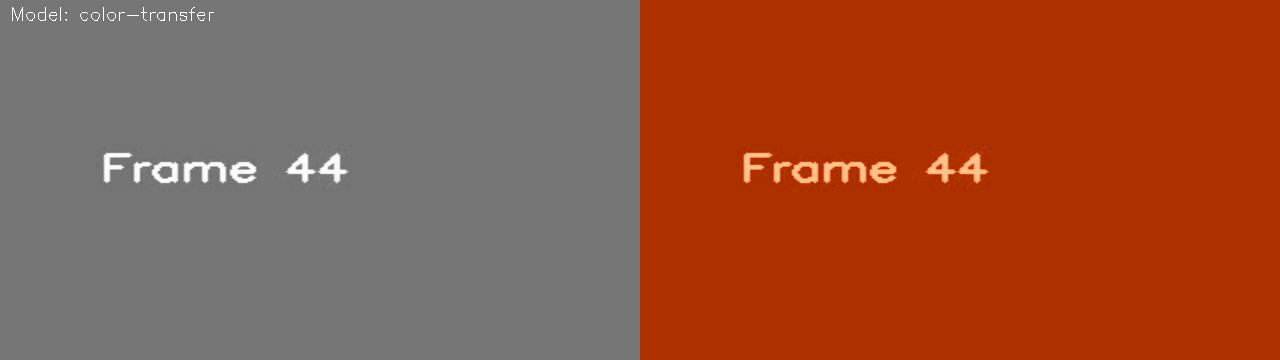

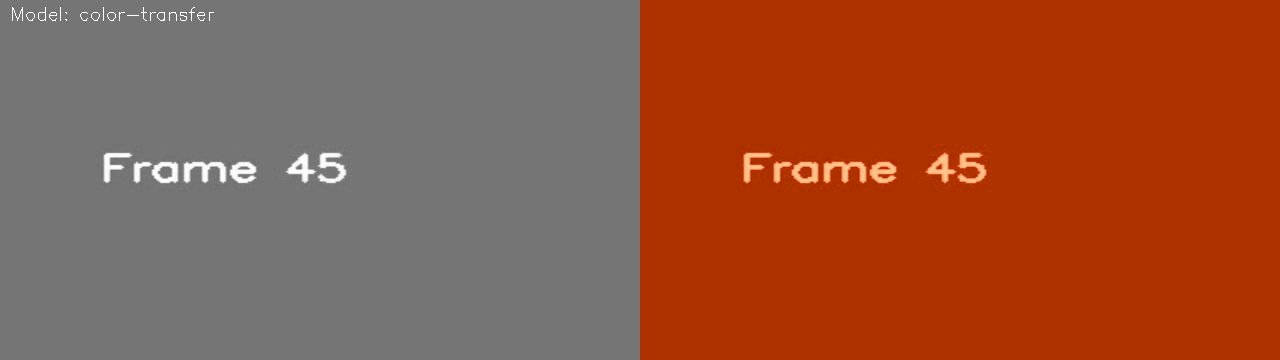

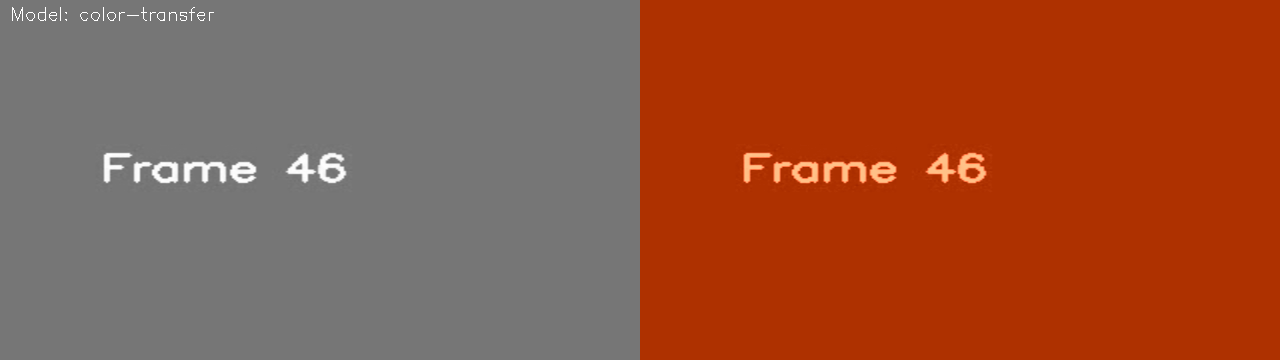

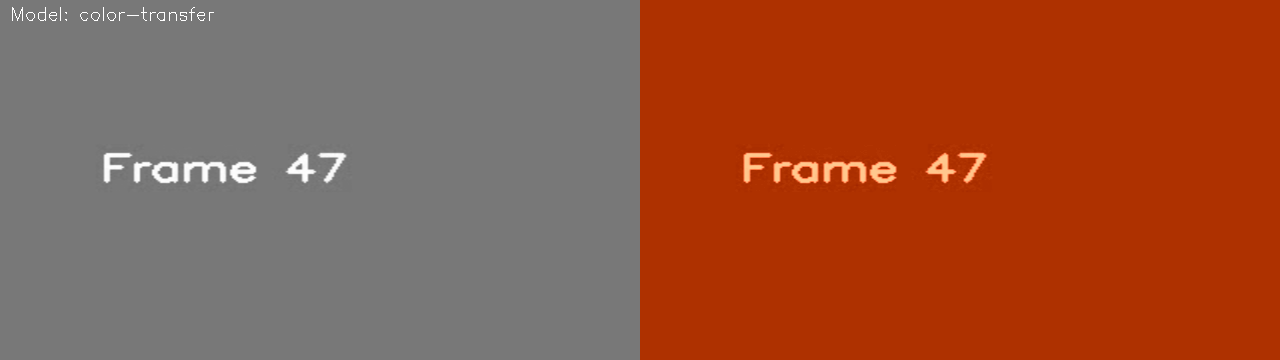

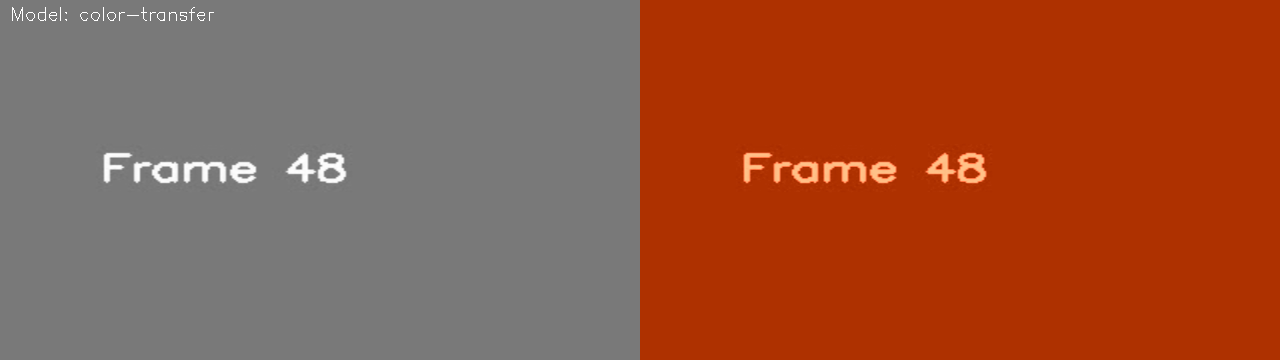

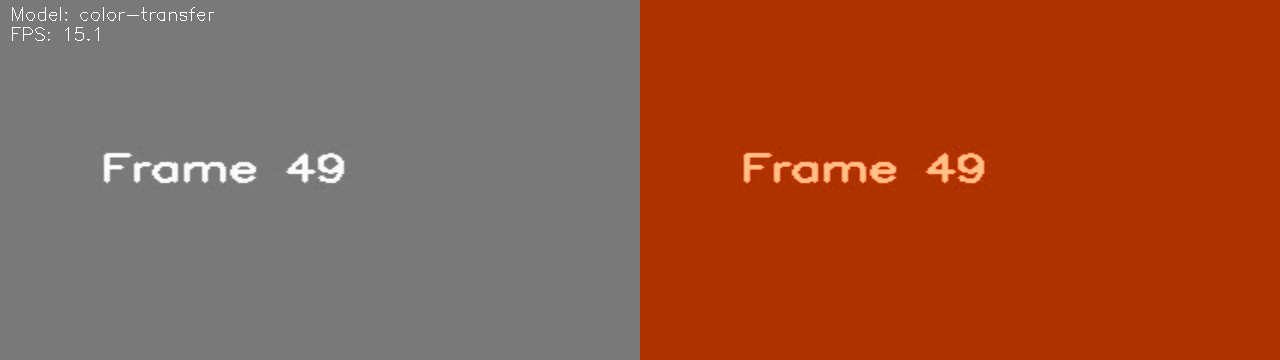

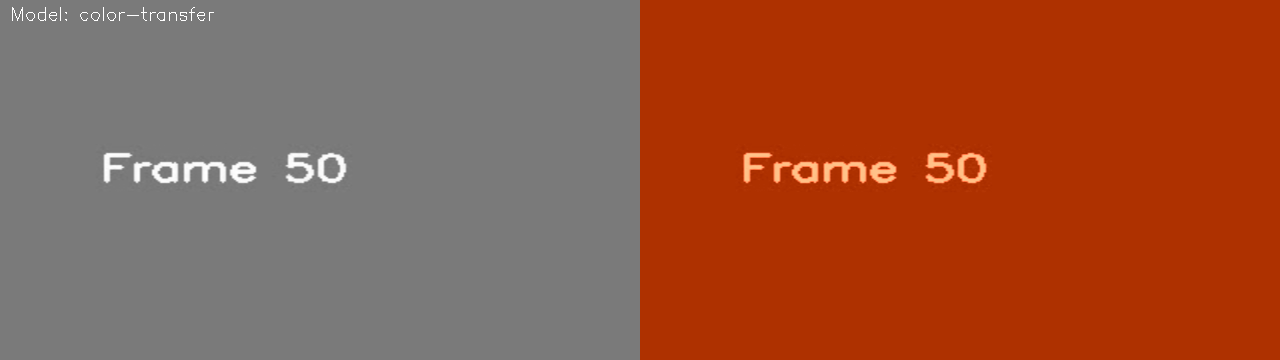

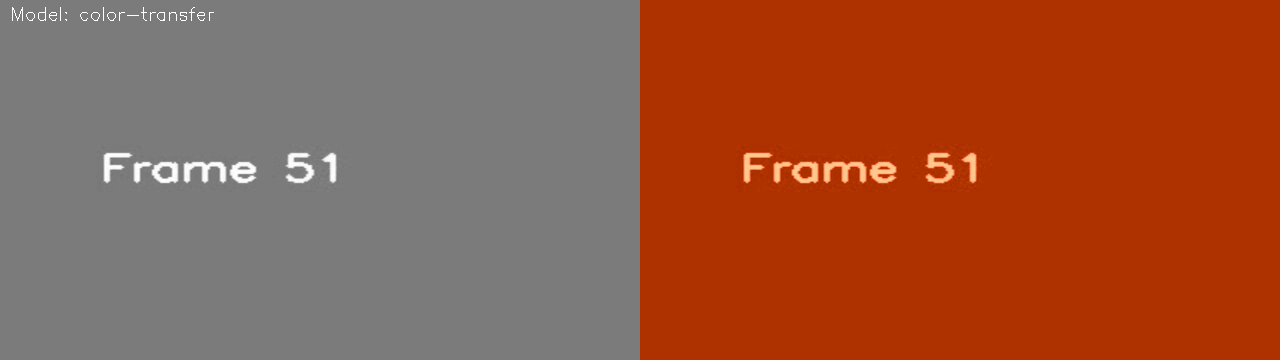

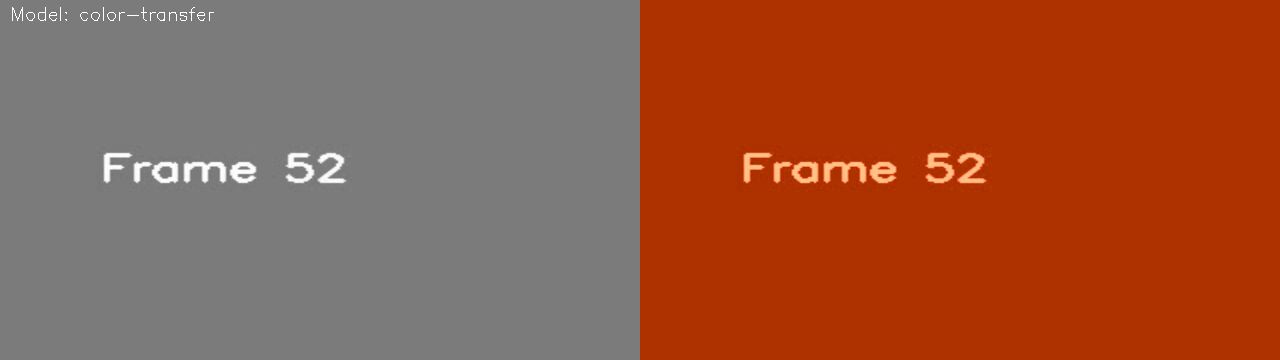

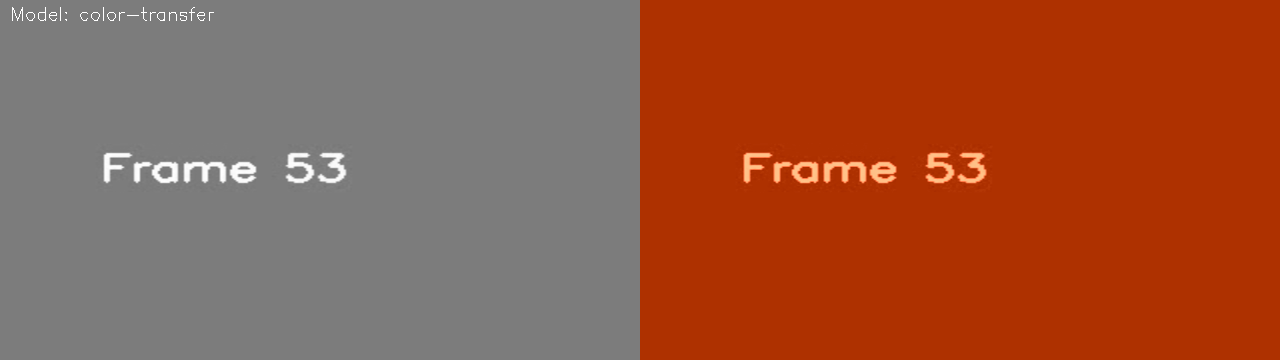

KeyboardInterrupt: 

In [35]:
# Example usage of the process_video function
# Replace '/mnt/data/colab_test_video.mp4' with the actual path to your video file
process_video(source='/content/colab_test_video.mp4', out_path='colorized_output.mp4')